In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc
import seaborn as sns

from utils import interp_ds, load_config, default_params

sns.set_theme("notebook")

In [2]:
def calc_eke(ds, params, xstart=20, xstop=70, tstart=8*60):
    ds = interp_ds(ds, params, ["u", "v"])
    ds = ds.isel(xC=slice(xstart,xstop), time=slice(tstart,None))

    
    u = ds.u 
    v = ds.v
    H = ds.h.isel(time=1).squeeze()
    a = params["dx"]*params["dy"]

    umean = u.mean(["yC", "xC"])
    vmean = v.mean(["yC", "xC"])

    unod = u - umean 
    vnod = v - vmean 

    Unod2 = unod**2 * H * a
    Vnod2 = vnod**2 * H * a

    EKE = 0.5*(Unod2.sum(["yC", "xC"])+Vnod2.sum(["yC", "xC"]))
    
    return EKE

def calc_mke(ds, params, xstart=20, xstop=70, tstart=8*60):
    ds = interp_ds(ds, params, ["u", "v"])
    ds = ds.isel(xC=slice(xstart,xstop), time=slice(tstart,None))
    
    u = ds.u 
    v = ds.v
    H = ds.h.isel(time=1).squeeze()
    a = params["dx"]*params["dy"]

    umean = u.mean(["yC", "xC"])
    vmean = v.mean(["yC", "xC"])

    Umean2 = umean**2 * H * a
    Vmean2 = vmean**2 * H * a

    EKE = 0.5*(Umean2.sum(["yC", "xC"]) + Vmean2.sum(["yC", "xC"]))
    
    return EKE

def hanning_filter(da, window_length = 6*8):
    # following http://xarray.pydata.org/en/stable/computation.html#rolling-window-operations
    hamming = np.hanning(window_length)
    window = xr.DataArray(hamming/np.sum(hamming), dims=['window'])
    rolling = da.rolling(time=window_length, center=True)
    filtered = rolling.construct(time='window').dot(window)
    
    return filtered

def calc_eke_mke(ds, params, xstart=20, xstop=70, tstart=8*60, window=6*8):
    ds = interp_ds(ds, params, ["u", "v"])
    #ds = ds.isel(xC=slice(xstart,xstop), time=slice(tstart,None))

    u = ds.u 
    v = ds.v
    H = ds.h.isel(time=1).squeeze()
    a = params["dx"]*params["dy"]

    umean = hanning_filter(u, window_length=window)
    vmean = hanning_filter(v, window_length=window)
    unod = u - umean 
    vnod = v - vmean 


    Unod2 = unod**2 * H * a
    Vnod2 = vnod**2 * H * a
    
    Umean2 = umean**2 * H * a
    Vmean2 = vmean**2 * H * a

    EKE = 0.5*(Unod2.sum(["yC", "xC"])+Vnod2.sum(["yC", "xC"]))
    MKE = 0.5*(Umean2.sum(["yC", "xC"])+Vmean2.sum(["yC", "xC"]))
    
    return EKE, MKE


def calc_enstrophy(ds, params, xstart=20, xstop=70, tstart=8*60):
    ds = interp_ds(ds, params, ["omega"])
    
    ds = ds.isel(xC=slice(xstart,xstop), time=slice(tstart,None))
    enstrophy = 0.5*(ds.omega**2).mean(["xC", "yC"])
    
    return enstrophy


def calc_vorticity_contribution(config, depth=500, tstart=8*60):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/extracted_circ/{config}_circ.nc").squeeze()
    ds = ds.isel(time=slice(tstart,None))
    ds = ds.sel(depth=depth)
    
    return ds.circulation-ds.linear_estimate

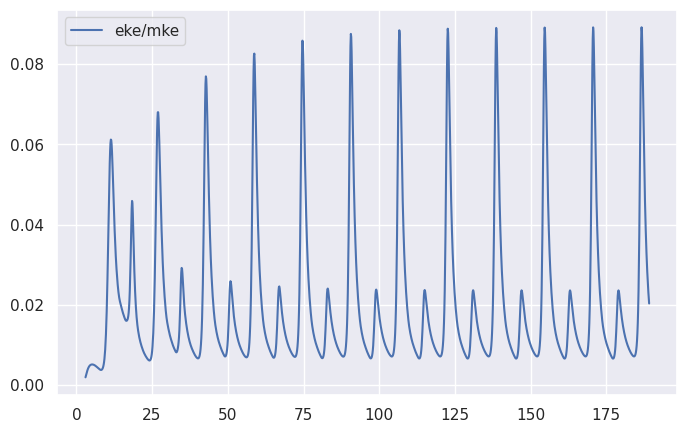

In [15]:
config = "slope-003"
ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)


window = 6*8
eke, mke = calc_eke_mke(ds, params , tstart=0, window=window)

t_days = eke.time / np.timedelta64(1, 'D')

fig, ax = plt.subplots(figsize=(8,5))

#ax.plot(t_days, eke, label="EKE", color="darkorange")
#ax.plot(t_days, mke, label="MKE", color="cornflowerblue")

ax.plot(t_days, (eke/mke), label="eke/mke")
#ax.plot(t_days, eke+mke, label="sum", color="black")

ax.legend()

ds_out=xr.Dataset()
ds_out["eke"] = eke
ds_out["mke"] = mke
ds_out["time"] = t_days.data
ds_out.attrs["smoothing window in days"] = window/8
ds_out.to_netcdf(f"../output/for_plotting/eke_mke_{config}.nc")


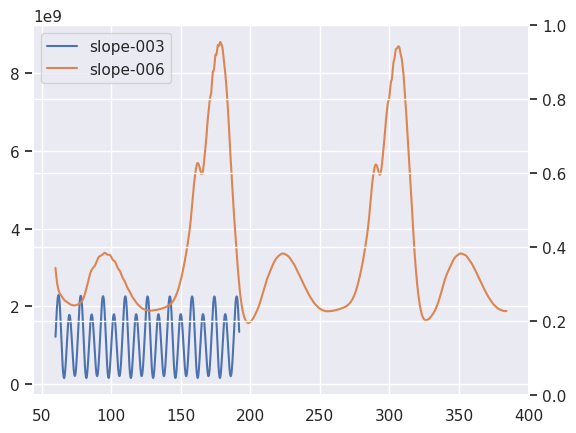

In [11]:
fig, ax = plt.subplots()

axt = ax.twinx()

configs = ["slope-003", "slope-006"]
for config in configs:
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)

    EKE = calc_eke(ds, params)
    t_days = EKE.time / np.timedelta64(1, 'D')
    ax.plot(t_days, EKE, label=config)
    
ax.legend()

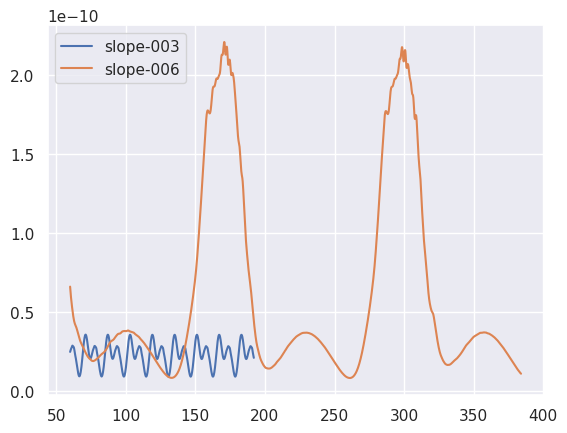

In [5]:
fig, ax = plt.subplots()

configs = ["slope-003", "slope-006"]
for config in configs:
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)
    
    enstrophy = calc_enstrophy(ds, params)
    t_days = enstrophy.time / np.timedelta64(1, 'D')
    
    ax.plot(t_days, enstrophy, label=config)
    
ax.legend()

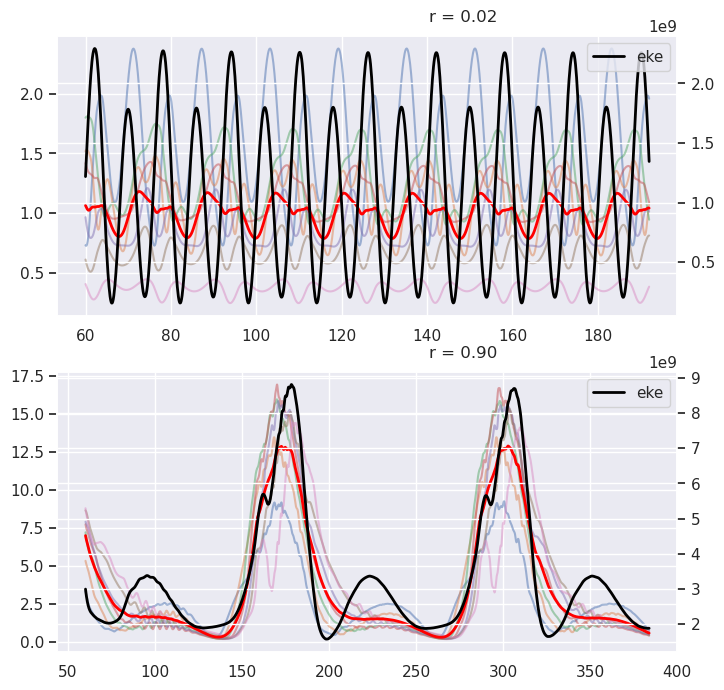

In [6]:
fig, axes = plt.subplots(nrows=len(configs), figsize=(8,8))
                         
for config, ax in zip(configs, axes):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)
    
    eke = calc_eke(ds, params)
    t_days = eke.time / np.timedelta64(1, 'D')
    axt = ax.twinx()
    
    axt.plot(t_days, eke, color="black",label="eke", lw=2)
    
    
    vsum = np.zeros_like(eke)
    depths = [200,300, 400, 500,600, 700, 800]
    for depth in depths:
        vcont = calc_vorticity_contribution(config, depth=depth)
        vsum += vcont.values
        ax.plot(vcont.time, vcont, 
                 label=depth,
                 alpha = 0.5
                 #color="darkorange"
                 )
    
    vsum /= len(depths)
    ax.plot(t_days, vsum, lw=2, color="red")
    
    #ax.legend(loc="upper left", ncols=2)
    axt.legend(loc="upper right")
    
    r = np.corrcoef(eke, vsum)[0,1]
    ax.text(0.6, 1.05, f"r = {r:.2f}", transform=ax.transAxes)

/tmp/ipykernel_200383/993692631.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axt.legend(loc="upper right")
/tmp/ipykernel_200383/993692631.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axt.legend(loc="upper right")


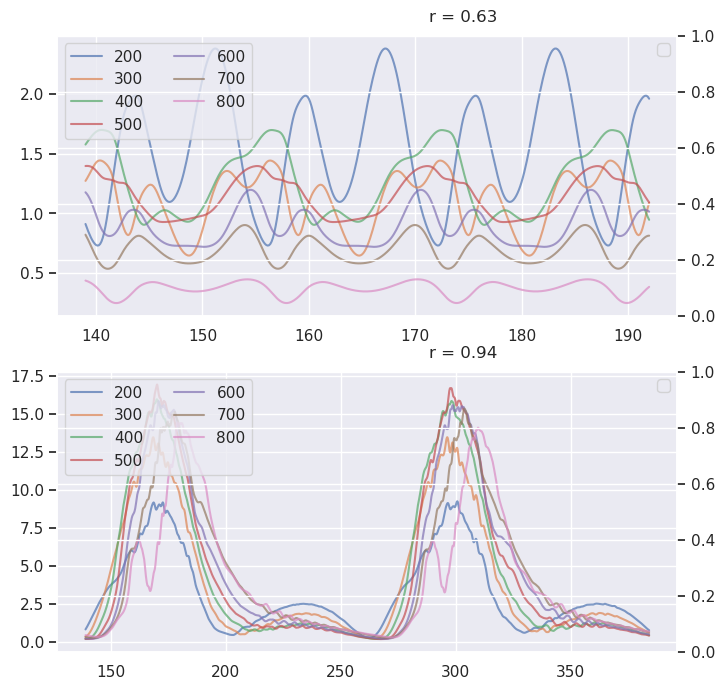

In [7]:
fig, axes = plt.subplots(nrows=len(configs), figsize=(8,8))
                         
for config, ax in zip(configs, axes):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)    
    
    enstrophy = calc_enstrophy(ds, params, tstart=(75+64)*8)
    t_days = enstrophy.time / np.timedelta64(1, 'D')
    axt = ax.twinx()
    
    #axt.plot(t_days, enstrophy, color="black",label="enstrophy", lw=1)
    
    
    vsum = np.zeros_like(enstrophy)
    depths = [200,300, 400, 500, 600, 700, 800]
    #depths = [500]
    for depth in depths:
        vcont = calc_vorticity_contribution(config, depth=depth, tstart=(75+64)*8)
        vsum += vcont.values
        ax.plot(vcont.time, vcont, 
                 label=depth,
                 alpha = 0.7
                 #color="darkorange"
                 )
    
    vsum /= len(depths)
    #ax.plot(t_days, vsum, lw=1, color="red")
    
    ax.legend(loc="upper left", ncols=2)
    axt.legend(loc="upper right")
    
    r = np.corrcoef(enstrophy, vsum)[0,1]
    ax.text(0.6, 1.05, f"r = {r:.2f}", transform=ax.transAxes)

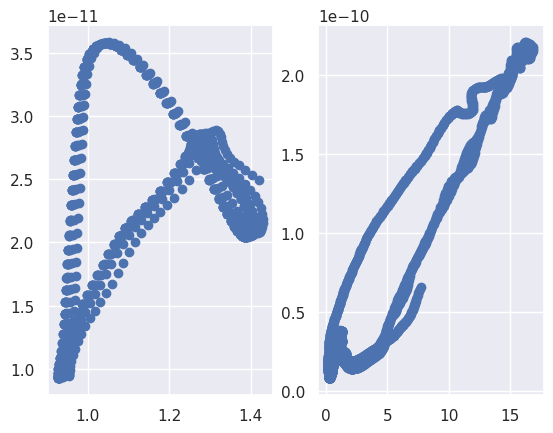

In [8]:
fig, axes = plt.subplots(ncols=len(configs))
                         
for config, ax in zip(configs, axes):
    ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
    params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)
    
    enstrophy = calc_enstrophy(ds, params)
    vcont = calc_vorticity_contribution(config)
    ax.scatter(vcont, enstrophy)

(-7546555558.482925, 40000000000.0)

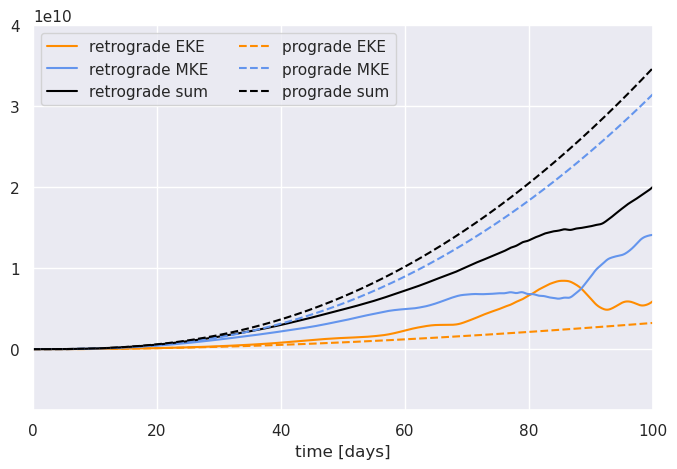

In [9]:
retrograde = "slope-055"

dsr = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{retrograde}.nc").squeeze()
paramsr = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{retrograde}.json", default_params)


eker = calc_eke(dsr, paramsr, tstart=0)
mker = calc_mke(dsr, paramsr, tstart=0)

prograde = "slope-054"

dsp = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{prograde}.nc").squeeze()
paramsp = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{prograde}.json", default_params)


ekep = calc_eke(dsp, paramsp , tstart=0)
mkep = calc_mke(dsp, paramsp , tstart=0)

t_days = eker.time / np.timedelta64(1, 'D')

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t_days, eker, label="retrograde EKE", color="darkorange")
ax.plot(t_days, mker, label="retrograde MKE", color="cornflowerblue")
ax.plot(t_days, eker+mker, label="retrograde sum", color="black")
ax.plot(t_days, ekep, label="prograde EKE", color="darkorange", ls="--")
ax.plot(t_days, mkep, label="prograde MKE", color="cornflowerblue", ls="--")
ax.plot(t_days, ekep+mkep, label="prograde sum", color="black", ls="--")

ax.legend(ncols=2)
ax.set_xlabel("time [days]")
ax.set_xlim(0,100)
ax.set_ylim(None, 0.4e11)